In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1 

In [4]:
train=pd.read_csv('../../1. Task and Data/train.csv',sep='|')

In [5]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

In [6]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer


def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)

# Model factory

In [12]:
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


model_tuning_factory = [
    GridSearchCV(SVC(),                                           
                 dict(C = [0.01, 0.1, 0.5, 1, 2]),
                 cv = skf,
                 scoring = my_custom_score,
                n_jobs = -1),    
]           
                 
                 
iterations = 10                
               
model_tuning_factory_randomized = [
    RandomizedSearchCV(SVC(),                                       
                 dict(C = [0.01, 0.1, 0.5, 1, 2]),
                 cv = skf,
                 scoring = my_custom_score,
                      n_iter  = iterations,
                      n_jobs = -1)
]

In [9]:
Y = train['fraud']
X = train.drop('fraud',axis=1)

In [13]:
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

result_table = pd.DataFrame(columns=["Model", "Data Preparation", "Feature Count", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


for data_preparation_strategy in range(1,5):
    if (data_preparation_strategy == 1):  
        X_scaled = X
        data_preparation = "No Scaling"
    elif (data_preparation_strategy == 2):
        feature_scaler = MinMaxScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
        data_preparation = "MinMaxScaler"
    elif (data_preparation_strategy == 3):
        feature_scaler = StandardScaler()  
        X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
        data_preparation = "StandardScaler"
    elif (data_preparation_strategy == 4):
        transformer = FunctionTransformer(np.log1p, validate=True)  
        X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
        data_preparation = "LogScaler"    

    for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results


        for feature_count in range(1,len(list(X))+1):

            model.seed = 42
            start_time = time.time()              


            # Solution with SelectKBest
            best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
            best_feature_list = X.columns[best_features.get_support()]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]

            result_table = result_table.append({
             "Model": model_name, 
             "Data Preparation": data_preparation,   
             "Feature Count": feature_count,
             "Feature Selection Technique": "SelectKBest",   
             "Features": best_feature_list.values, 
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,   
             "Raw Model": model.best_estimator_
              }, ignore_index=True)


            # Solution with Recursive Feature Elimination -> only works for some models

            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

               # Traditional RFE
                rfe = RFE(model.estimator, n_features_to_select = feature_count)
                rfe = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]


                result_table = result_table.append({
                 "Model": model_name, 
                 "Data Preparation": data_preparation,
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "RFE",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,  
                 "Raw Model": model.best_estimator_
                  }, ignore_index=True)

            end_time = time.time()

            print("Finished " + model.best_estimator_.__class__.__name__ + " with " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")



        if (model.estimator.__class__.__name__ == 'LogisticRegression'
         or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
         or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
         or model.estimator.__class__.__name__ == 'RandomForestClassifier'
         or model.estimator.__class__.__name__ == 'BernoulliNB'
         or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
         or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
         or model.estimator.__class__.__name__ == 'Perceptron'
         or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

            # RFE with Cross Validation -> determines the optimum feature count automatically
            rfecv = RFECV(model.estimator, cv = skf, scoring = my_custom_score)
            rfecv = rfe.fit(X,Y)
            best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
            X_selected_features = X[best_feature_list]

            model.fit(X_selected_features,Y)  
            model_name = model.best_estimator_.__class__.__name__
            score_mean = model.cv_results_['mean_test_score'][model.best_index_]
            score_std = model.cv_results_['std_test_score'][model.best_index_]


            result_table = result_table.append({
             "Model": model_name,  
             "Data Preparation": data_preparation,
             "Feature Count": len(best_feature_list),
             "Feature Selection Technique": "RFECV",
             "Features": best_feature_list,
             "Optimal Parameters": model.best_params_,
             "Monetary Value Per Instance - Mean":  score_mean,
             "Monetary Value Per Instance - Standard Deviation": score_std,    
             "Raw Model": model.best_estimator_
              }, ignore_index=True)

result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished SVC with No Scaling and 1 features after 12.22 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with No Scaling and 2 features after 0.62 seconds
Finished SVC with No Scaling and 3 features after 10.88 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with No Scaling and 4 features after 9.46 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with No Scaling and 5 features after 6.88 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with No Scaling and 6 features after 6.14 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with No Scaling and 7 features after 6.04 seconds
Finished SVC with No Scaling and 8 features after 6.57 seconds
Finished SVC with No Scaling and 9 features after 7.38 seconds
Finished SVC with No Scaling and 10 features after 5.58 seconds
Finished SVC with No Scaling and 11 features after 5.24 seconds
Finished SVC with No Scaling and 12 features after 5.67 seconds
Finished SVC with No Scaling and 13 features after 5.51 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with No Scaling and 14 features after 4.91 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with No Scaling and 15 features after 5.47 seconds
Finished SVC with No Scaling and 16 features after 4.52 seconds
Finished SVC with No Scaling and 17 features after 5.88 seconds
Finished SVC with No Scaling and 18 features after 5.71 seconds
Finished SVC with No Scaling and 19 features after 5.76 seconds
Finished SVC with No Scaling and 20 features after 5.71 seconds
Finished SVC with MinMaxScaler and 1 features after 3.02 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with MinMaxScaler and 2 features after 1.29 seconds
Finished SVC with MinMaxScaler and 3 features after 2.82 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with MinMaxScaler and 4 features after 5.06 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with MinMaxScaler and 5 features after 7.03 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with MinMaxScaler and 6 features after 8.26 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with MinMaxScaler and 7 features after 5.95 seconds
Finished SVC with MinMaxScaler and 8 features after 7.44 seconds
Finished SVC with MinMaxScaler and 9 features after 7.19 seconds
Finished SVC with MinMaxScaler and 10 features after 8.62 seconds
Finished SVC with MinMaxScaler and 11 features after 8.36 seconds
Finished SVC with MinMaxScaler and 12 features after 10.15 seconds
Finished SVC with MinMaxScaler and 13 features after 9.37 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with MinMaxScaler and 14 features after 12.71 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with MinMaxScaler and 15 features after 13.31 seconds
Finished SVC with MinMaxScaler and 16 features after 9.59 seconds
Finished SVC with MinMaxScaler and 17 features after 9.38 seconds
Finished SVC with MinMaxScaler and 18 features after 11.78 seconds
Finished SVC with MinMaxScaler and 19 features after 15.24 seconds
Finished SVC with MinMaxScaler and 20 features after 9.66 seconds
Finished SVC with StandardScaler and 1 features after 8.0 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with StandardScaler and 2 features after 0.58 seconds
Finished SVC with StandardScaler and 3 features after 10.49 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with StandardScaler and 4 features after 10.27 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with StandardScaler and 5 features after 5.46 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with StandardScaler and 6 features after 4.46 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with StandardScaler and 7 features after 4.73 seconds
Finished SVC with StandardScaler and 8 features after 5.94 seconds
Finished SVC with StandardScaler and 9 features after 5.05 seconds
Finished SVC with StandardScaler and 10 features after 4.9 seconds
Finished SVC with StandardScaler and 11 features after 4.89 seconds
Finished SVC with StandardScaler and 12 features after 7.63 seconds
Finished SVC with StandardScaler and 13 features after 9.16 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with StandardScaler and 14 features after 6.35 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with StandardScaler and 15 features after 6.55 seconds
Finished SVC with StandardScaler and 16 features after 10.13 seconds
Finished SVC with StandardScaler and 17 features after 7.0 seconds
Finished SVC with StandardScaler and 18 features after 9.82 seconds
Finished SVC with StandardScaler and 19 features after 6.73 seconds
Finished SVC with StandardScaler and 20 features after 6.9 seconds
Finished SVC with LogScaler and 1 features after 8.04 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 2 features after 5.04 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 3 features after 4.0 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 4 features after 3.27 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 5 features after 4.36 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 6 features after 1.05 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 7 features after 7.76 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 8 features after 5.84 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 9 features after 4.99 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 10 features after 9.03 seconds
Finished SVC with LogScaler and 11 features after 10.87 seconds
Finished SVC with LogScaler and 12 features after 11.61 seconds
Finished SVC with LogScaler and 13 features after 10.99 seconds


C:\Users\ahuem\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Finished SVC with LogScaler and 14 features after 10.05 seconds
Finished SVC with LogScaler and 15 features after 10.04 seconds
Finished SVC with LogScaler and 16 features after 9.41 seconds
Finished SVC with LogScaler and 17 features after 9.24 seconds
Finished SVC with LogScaler and 18 features after 9.45 seconds
Finished SVC with LogScaler and 19 features after 9.07 seconds
Finished SVC with LogScaler and 20 features after 10.22 seconds


,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
65,SVC,LogScaler,6,"[trustLevel, lineItemVoidsPerPosition, scanned...",{'C': 0.5},-0.146354,0.200883,"SVC(C=0.5, cache_size=200, class_weight=None, ...",SelectKBest
1,SVC,No Scaling,2,"[trustLevel, scannedLineItems]",{'C': 1},-0.159659,0.208667,"SVC(C=1, cache_size=200, class_weight=None, co...",SelectKBest
21,SVC,MinMaxScaler,2,"[trustLevel, scannedLineItems]",{'C': 1},-0.159659,0.208667,"SVC(C=1, cache_size=200, class_weight=None, co...",SelectKBest
41,SVC,StandardScaler,2,"[trustLevel, scannedLineItems]",{'C': 1},-0.159659,0.208667,"SVC(C=1, cache_size=200, class_weight=None, co...",SelectKBest
61,SVC,LogScaler,2,"[trustLevel, scannedLineItems]",{'C': 1},-0.159659,0.208667,"SVC(C=1, cache_size=200, class_weight=None, co...",SelectKBest
62,SVC,LogScaler,3,"[trustLevel, scannedLineItems, pricePerScanned...",{'C': 0.5},-0.159659,0.228302,"SVC(C=0.5, cache_size=200, class_weight=None, ...",SelectKBest
63,SVC,LogScaler,4,"[trustLevel, scannedLineItems, pricePerScanned...",{'C': 0.5},-0.159659,0.228302,"SVC(C=0.5, cache_size=200, class_weight=None, ...",SelectKBest
64,SVC,LogScaler,5,"[trustLevel, lineItemVoidsPerPosition, scanned...",{'C': 0.5},-0.159659,0.228302,"SVC(C=0.5, cache_size=200, class_weight=None, ...",SelectKBest
57,SVC,StandardScaler,18,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'C': 0.01},-0.276743,0.011709,"SVC(C=0.01, cache_size=200, class_weight=None,...",SelectKBest
55,SVC,StandardScaler,16,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'C': 0.01},-0.276743,0.011709,"SVC(C=0.01, cache_size=200, class_weight=None,...",SelectKBest


In [14]:
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Data Preparation,Feature Count,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Feature Selection Technique
65,SVC,LogScaler,6,"[trustLevel, lineItemVoidsPerPosition, scanned...",{'C': 0.5},-0.146354,0.200883,"SVC(C=0.5, cache_size=200, class_weight=None, ...",SelectKBest
1,SVC,No Scaling,2,"[trustLevel, scannedLineItems]",{'C': 1},-0.159659,0.208667,"SVC(C=1, cache_size=200, class_weight=None, co...",SelectKBest
21,SVC,MinMaxScaler,2,"[trustLevel, scannedLineItems]",{'C': 1},-0.159659,0.208667,"SVC(C=1, cache_size=200, class_weight=None, co...",SelectKBest
41,SVC,StandardScaler,2,"[trustLevel, scannedLineItems]",{'C': 1},-0.159659,0.208667,"SVC(C=1, cache_size=200, class_weight=None, co...",SelectKBest
61,SVC,LogScaler,2,"[trustLevel, scannedLineItems]",{'C': 1},-0.159659,0.208667,"SVC(C=1, cache_size=200, class_weight=None, co...",SelectKBest
62,SVC,LogScaler,3,"[trustLevel, scannedLineItems, pricePerScanned...",{'C': 0.5},-0.159659,0.228302,"SVC(C=0.5, cache_size=200, class_weight=None, ...",SelectKBest
63,SVC,LogScaler,4,"[trustLevel, scannedLineItems, pricePerScanned...",{'C': 0.5},-0.159659,0.228302,"SVC(C=0.5, cache_size=200, class_weight=None, ...",SelectKBest
64,SVC,LogScaler,5,"[trustLevel, lineItemVoidsPerPosition, scanned...",{'C': 0.5},-0.159659,0.228302,"SVC(C=0.5, cache_size=200, class_weight=None, ...",SelectKBest
57,SVC,StandardScaler,18,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'C': 0.01},-0.276743,0.011709,"SVC(C=0.01, cache_size=200, class_weight=None,...",SelectKBest
55,SVC,StandardScaler,16,"[trustLevel, totalScanTimeInSeconds, lineItemV...",{'C': 0.01},-0.276743,0.011709,"SVC(C=0.01, cache_size=200, class_weight=None,...",SelectKBest


In [16]:
#result_table.to_pickle("result_table_SVC.pkl")
result_table = pd.read_pickle("result_table_SVC.pkl")

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

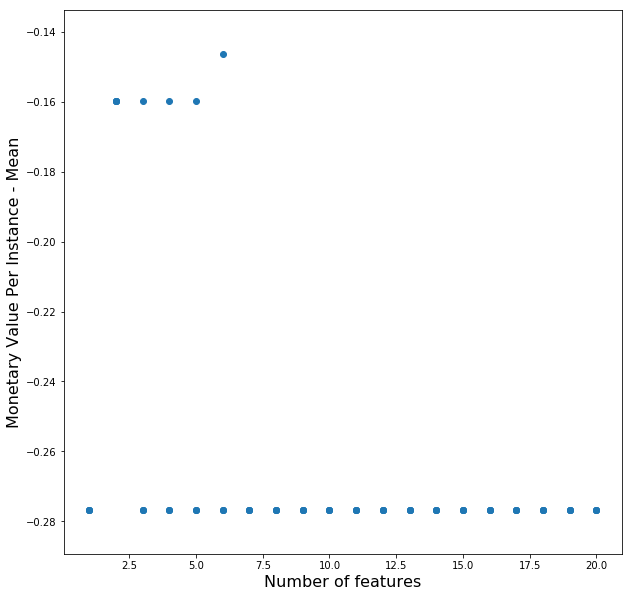

In [17]:
plt.rcParams['figure.figsize'] = (10,10)

plt.scatter(result_table["Feature Count"], result_table["Monetary Value Per Instance - Mean"])
plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [18]:
best_model = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Features"]
best_parameters = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(best_model)
print(best_model_features)
print(best_parameters)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
['trustLevel' 'lineItemVoidsPerPosition' 'scannedLineItems'
 'pricePerScannedLineItem' 'scansWithoutRegistrationPerScannedLineItem'
 'quantityModificationsPerScannedLineItem']
{'C': 0.5}


In [19]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(Y , best_model.predict(X[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1759
False positive:  16
False negative:  37
True positive:  67
-250 for 1879 instances in the test set
-0.13304949441192124 per instance in the test set
